<a href="https://colab.research.google.com/github/Flat-Chen/Chatglm_lora_multi-gpu/blob/main/examples/image_classification_albumentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine-tuning for Image Classification with 🤗 Transformers**

This notebook shows how to fine-tune any pretrained Vision model for Image Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## ImageFolder feature

This notebook leverages the [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to easily run the notebook on a custom dataset (namely, [EuroSAT](https://github.com/phelber/EuroSAT) in this tutorial). You can either load a `Dataset` from local folders or from local/remote files, like zip or tar.

## Any model

This notebook is built to run on any image classification dataset with any vision model checkpoint from the [Model Hub](https://huggingface.co/) as long as that model has a version with a Image Classification head, such as:
* [ViT](https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification)
* [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin#transformers.SwinForImageClassification)
* [ConvNeXT](https://huggingface.co/docs/transformers/master/en/model_doc/convnext#transformers.ConvNextForImageClassification)

- in short, any model supported by [AutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification).

## Albumentations

In this notebook, we are going to leverage the [Albumentations](https://albumentations.ai/docs/) library for data augmentation. Note that we have other versions of this notebook available as well with other libraries including:

* [Torchvision's Transforms](https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb)
* [Kornia](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_kornia.ipynb)
* [imgaug](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_imgaug.ipynb).

------
Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In this notebook, we'll fine-tune from the https://huggingface.co/facebook/convnext-tiny-224 checkpoint, but note that there are many, many more available on the hub.

In [6]:
model_checkpoint = "google/vit-base-patch32-384" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

Before we start, let's install the `datasets`, `transformers` and `albumentations` libraries.

In [2]:
!pip install -q datasets==2.21.0 transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.6.1 which is incompatible.


In [3]:
!pip install -q albumentations

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [4]:
from huggingface_hub import notebook_login

notebook_login()


Then you need to install Git-LFS to upload your model checkpoints:

In [5]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [5]:
!unzip dataset_plus.zip

Archive:  dataset_plus.zip
   creating: test/answer/
  inflating: test/answer/104_2_answer.jpg  
  inflating: test/answer/104_3_answer.jpg  
  inflating: test/answer/104_4_answer.jpg  
  inflating: test/answer/104_5_answer.jpg  
  inflating: test/answer/136_2_answer.jpg  
  inflating: test/answer/136_3_answer.jpg  
  inflating: test/answer/136_4_answer.jpg  
  inflating: test/answer/14_2_answer.jpg  
  inflating: test/answer/14_3_answer.jpg  
  inflating: test/answer/14_4_answer.jpg  
  inflating: test/answer/14_5_answer.jpg  
  inflating: test/answer/170_3_answer.jpg  
  inflating: test/answer/170_4_answer.jpg  
  inflating: test/answer/170_5_answer.jpg  
  inflating: test/answer/170_6_answer.jpg  
  inflating: test/answer/170_7_answer.jpg  
  inflating: test/answer/208_2_answer.jpg  
  inflating: test/answer/208_3_answer.jpg  
  inflating: test/answer/208_4_answer.jpg  
  inflating: test/answer/213_2_answer.jpg  
  inflating: test/answer/213_3_answer.jpg  
  inflating: test/answer/21

In [18]:
from transformers.utils import send_example_telemetry

send_example_telemetry("image_classification_albumentations_notebook", framework="pytorch")

## Fine-tuning a model on an image classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on an Image Classification dataset.

Given an image, the goal is to predict an appropriate class for it, like "tiger". The screenshot below is taken from a [ViT fine-tuned on ImageNet-1k](https://huggingface.co/google/vit-base-patch16-224) - try out the inference widget!

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/tiger_image.png" alt="drawing" width="600"/>


### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library's [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to download our custom dataset into a DatasetDict.

In this case, the EuroSAT dataset is hosted remotely, so we provide the `data_files` argument. Alternatively, if you have local folders with images, you can load them using the `data_dir` argument.

In [ ]:
from datasets import load_dataset

# load a custom dataset from local/remote files using the ImageFolder feature

# option 1: local/remote files (supporting the following formats: tar, gzip, zip, xz, rar, zstd)
dataset = load_dataset("imagefolder", data_files="https://madm.dfki.de/files/sentinel/EuroSAT.zip")

# note that you can also provide several splits:
# dataset = load_dataset("imagefolder", data_files={"train": ["path/to/file1", "path/to/file2"], "test": ["path/to/file3", "path/to/file4"]})

# note that you can push your dataset to the hub very easily (and reload afterwards using load_dataset)!
# dataset.push_to_hub("nielsr/eurosat")
# dataset.push_to_hub("nielsr/eurosat", private=True)

# option 2: local folder
# dataset = load_dataset("imagefolder", data_dir="path_to_folder")

# option 3: just load any existing dataset from the hub ...
# dataset = load_dataset("cifar10")

Using custom data configuration default-0537267e6f812d56


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-0537267e6f812d56/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [7]:
from datasets import load_dataset, DatasetDict

# 分别加载 train、val 和 test 拆分
train_data = load_dataset('imagefolder', data_dir='train')
val_data = load_dataset('imagefolder', data_dir='test')
test_data = load_dataset('imagefolder', data_dir='val')

# 将不同拆分合并到一个 DatasetDict
dataset = DatasetDict({
    'train': train_data['train'],
    'val': val_data['train'],  # 注意这里还是叫 'train'，我们用来表示 'val'
    'test': test_data['train'],  # 同样这里也是 'train' 表示 'test'
})

Resolving data files:   0%|          | 0/1618 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/114 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-8-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, only "train" for a training split).

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1618
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 73
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 114
    })
})

To access an actual element, you need to select a split first, then give an index:

In [10]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=586x85>,
 'label': 0}

Each example consists of an image and a corresponding label. We can also verify this by checking the features of the dataset:

In [15]:
dataset["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['answer', 'delete_line'], id=None)}

The cool thing is that we can directly view the image (as the 'image' field is an [Image feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Image)), as follows:

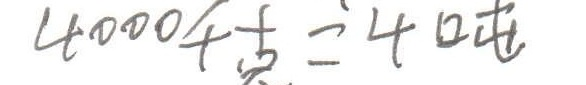

In [16]:
example['image']

Let's make it a little bigger as the images in the EuroSAT dataset are of low resolution (64x64 pixels):

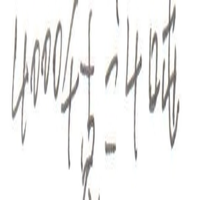

In [17]:
example['image'].resize((200, 200))

Let's check the corresponding label:

In [ ]:
example['label']

2

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [ ]:
dataset["train"].features["label"]

ClassLabel(num_classes=10, names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [11]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[1]

'delete_line'

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them.

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `Albumentations` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [torchvision's transforms](https://pytorch.org/vision/stable/transforms.html), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/), etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called an image processor with the `AutoImageProcessor.from_pretrained` method.

This image processor is a minimal preprocessor that can be used to prepare images for inference.

In [19]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing).

In [21]:
size

(384, 384)

In [23]:
import cv2
import albumentations as A
import numpy as np

if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")
size=384
train_transforms = A.Compose([
    A.Resize(height=size, width=size),
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
])

val_transforms = A.Compose([
    A.Resize(height=size, width=size),
    A.Normalize(),
])

def preprocess_train(examples):
    examples["pixel_values"] = [
        train_transforms(image=np.array(image))["image"] for image in examples["image"]
    ]

    return examples

def preprocess_val(examples):
    examples["pixel_values"] = [
        val_transforms(image=np.array(image))["image"] for image in examples["image"]
    ]

    return examples

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [ ]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [24]:
# split up training into training + validation
# splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = train_data['train']
val_ds = val_data['train']
test_ds = test_data['train']

In [25]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Let's check the first example:

In [26]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=228x30>,
 'label': 0,
 'pixel_values': array([[[1.700916 , 1.8683473, 2.0822659],
         [1.700916 , 1.8683473, 2.0822659],
         [1.700916 , 1.8683473, 2.0822659],
         ...,
         [1.7865398, 1.9558823, 2.1694117],
         [1.7865398, 1.9558823, 2.1694117],
         [1.7865398, 1.9558823, 2.1694117]],
 
        [[1.700916 , 1.8683473, 2.0822659],
         [1.700916 , 1.8683473, 2.0822659],
         [1.700916 , 1.8683473, 2.0822659],
         ...,
         [1.7865398, 1.9558823, 2.1694117],
         [1.7865398, 1.9558823, 2.1694117],
         [1.7865398, 1.9558823, 2.1694117]],
 
        [[1.700916 , 1.8683473, 2.0822659],
         [1.700916 , 1.8683473, 2.0822659],
         [1.700916 , 1.8683473, 2.0822659],
         ...,
         [1.7865398, 1.9558823, 2.1694117],
         [1.7865398, 1.9558823, 2.1694117],
         [1.7865398, 1.9558823, 2.1694117]],
 
        ...,
 
        [[1.7522904, 1.9208683, 2.13455

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Like with the image processor, the `from_pretrained` method will download and cache the model for us. As the label ids and the number of labels are dataset dependent, we pass `num_labels`, `label2id`, and `id2label` alongside the `model_checkpoint` he£re.

NOTE: in case you're planning to fine-tune an already fine-tuned checkpoint, like [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224) (which has already been fine-tuned on ImageNet-1k), then you need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head is thrown away and replaced by a new, randomly initialized classification head that includes a custom number of output neurons.

In [27]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you'd like to fine-tune an already fine-tuned checkpoint
)


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-384 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `pooler` layer) and randomly initializing some other (the weights and bias of the `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('img' in particular) in order to create 'pixel_values'.

In [28]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat-albumentations",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=50,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"nielsr/vit-finetuned-cifar10"` or `"huggingface/nielsr/vit-finetuned-cifar10"`).

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [29]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [30]:
import torch

def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        image = np.moveaxis(example["pixel_values"], source=2, destination=0)
        images.append(torch.from_numpy(image))
        labels.append(example["label"])

    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [31]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

<ipython-input-31-f220d94b5868>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


You might wonder why we pass along the `image_processor` as a tokenizer when we already preprocessed our data. This is only to make sure the image processor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [32]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
0,0.720400,0.569525,0.739726
1,0.426900,0.253684,0.917808
2,0.160500,0.334659,0.876712
3,0.075800,0.220343,0.904110
4,0.040500,0.356333,0.917808
5,0.035800,0.232649,0.931507
6,0.018800,0.204585,0.931507
7,0.026000,0.219492,0.890411
8,0.058200,0.337848,0.917808
9,0.011300,0.268480,0.917808


TrainOutput(global_step=600, training_loss=0.029281046726027854, metrics={'train_runtime': 3228.9748, 'train_samples_per_second': 25.054, 'train_steps_per_second': 0.186, 'total_flos': 1.7842338017574912e+19, 'train_loss': 0.029281046726027854, 'epoch': 47.98039215686274})

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [33]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.18705220520496368, 'eval_accuracy': 0.9726027397260274, 'eval_runtime': 1.0097, 'eval_samples_per_second': 72.3, 'eval_steps_per_second': 2.971, 'epoch': 47.98039215686274}


You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card for you, as well as adding Tensorboard metrics - see the "Training metrics" tab!):

In [34]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1731648282.7138667a1c9b.3210.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

events.out.tfevents.1731644855.7138667a1c9b.3210.0:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/CGscorpion/vit-base-patch32-384-finetuned-eurosat-albumentations/commit/0dedf828ec8368f23347126ca8fdfa5573ec8ddc', commit_message='End of training', commit_description='', oid='0dedf828ec8368f23347126ca8fdfa5573ec8ddc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/CGscorpion/vit-base-patch32-384-finetuned-eurosat-albumentations', endpoint='https://huggingface.co', repo_type='model', repo_id='CGscorpion/vit-base-patch32-384-finetuned-eurosat-albumentations'), pr_revision=None, pr_num=None)

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForImageClassification, AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("nielsr/my-awesome-model")
model = AutoModelForImageClassification.from_pretrained("nielsr/my-awesome-model")

```

## Inference

Let's say you have a new image, on which you'd like to make a prediction. Let's load a satellite image of a highway (that's not part of the EuroSAT dataset), and see how the model does.

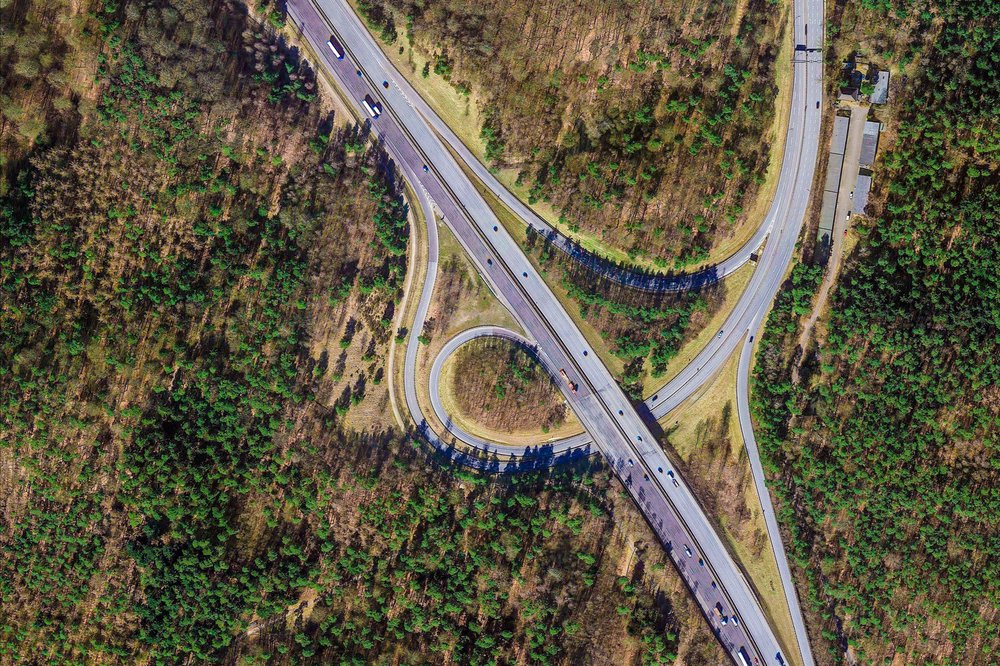

In [35]:
from PIL import Image
import requests

url = 'https://huggingface.co/nielsr/convnext-tiny-224-finetuned-eurosat-albumentations/resolve/main/highway.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

We'll load the image processor and model from the hub (here, we use the [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which will make sure the appropriate classes will be loaded automatically based on the `config.json` and `preprocessor_config.json` files of the repo on the hub):

In [ ]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "nielsr/convnext-tiny-224-finetuned-eurosat-albumentations"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

https://huggingface.co/nielsr/convnext-tiny-224-finetuned-eurosat-albumentations/resolve/main/preprocessor_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp04g0zg5n


Downloading:   0%|          | 0.00/266 [00:00<?, ?B/s]

storing https://huggingface.co/nielsr/convnext-tiny-224-finetuned-eurosat-albumentations/resolve/main/preprocessor_config.json in cache at /root/.cache/huggingface/transformers/38b41a2c904b6ce5bb10403bf902ee4263144d862c5a602c83cd120c0c1ba0e6.37be7274d6b5860aee104bb1fbaeb0722fec3850a85bb2557ae9491f17f89433
creating metadata file for /root/.cache/huggingface/transformers/38b41a2c904b6ce5bb10403bf902ee4263144d862c5a602c83cd120c0c1ba0e6.37be7274d6b5860aee104bb1fbaeb0722fec3850a85bb2557ae9491f17f89433
loading feature extractor configuration file https://huggingface.co/nielsr/convnext-tiny-224-finetuned-eurosat-albumentations/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/38b41a2c904b6ce5bb10403bf902ee4263144d862c5a602c83cd120c0c1ba0e6.37be7274d6b5860aee104bb1fbaeb0722fec3850a85bb2557ae9491f17f89433
Feature extractor ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeat

Downloading:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

storing https://huggingface.co/nielsr/convnext-tiny-224-finetuned-eurosat-albumentations/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/25088566ab29cf0ff360b05880b5f20cdc0c79ab995056a1fb4f98212d021154.4637c3f271a8dfbcfe5c4ee777270112d841a5af95814f0fd086c3c2761e7370
creating metadata file for /root/.cache/huggingface/transformers/25088566ab29cf0ff360b05880b5f20cdc0c79ab995056a1fb4f98212d021154.4637c3f271a8dfbcfe5c4ee777270112d841a5af95814f0fd086c3c2761e7370
loading configuration file https://huggingface.co/nielsr/convnext-tiny-224-finetuned-eurosat-albumentations/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/25088566ab29cf0ff360b05880b5f20cdc0c79ab995056a1fb4f98212d021154.4637c3f271a8dfbcfe5c4ee777270112d841a5af95814f0fd086c3c2761e7370
Model config ConvNextConfig {
  "_name_or_path": "nielsr/convnext-tiny-224-finetuned-eurosat-albumentations",
  "architectures": [
    "ConvNextForImageClassification"
  ],
  "depths": [
    3,
  

Downloading:   0%|          | 0.00/106M [00:00<?, ?B/s]

storing https://huggingface.co/nielsr/convnext-tiny-224-finetuned-eurosat-albumentations/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/3f4bcce35d3279d19b07fb762859d89bce636d8f0235685031ef6494800b9769.d611c768c0b0939188b05c3d505f0b36c97aa57649d4637e3384992d3c5c0b89
creating metadata file for /root/.cache/huggingface/transformers/3f4bcce35d3279d19b07fb762859d89bce636d8f0235685031ef6494800b9769.d611c768c0b0939188b05c3d505f0b36c97aa57649d4637e3384992d3c5c0b89
loading weights file https://huggingface.co/nielsr/convnext-tiny-224-finetuned-eurosat-albumentations/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/3f4bcce35d3279d19b07fb762859d89bce636d8f0235685031ef6494800b9769.d611c768c0b0939188b05c3d505f0b36c97aa57649d4637e3384992d3c5c0b89
All model checkpoint weights were used when initializing ConvNextForImageClassification.

All the weights of ConvNextForImageClassification were initialized from the model checkpoint at niel

In [36]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 384, 384])


In [38]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [39]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

NameError: name 'logits' is not defined

Looks like our model got it correct!

## Pipeline API

An alternative way to quickly perform inference with any model on the hub is by leveraging the [Pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines), which abstracts away all the steps we did manually above for us. It will perform the preprocessing, forward pass and postprocessing all in a single object.

Let's showcase this for our trained model:

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", "nielsr/convnext-tiny-224-finetuned-eurosat-albumentations")

loading configuration file https://huggingface.co/nielsr/convnext-tiny-224-finetuned-eurosat-albumentations/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/25088566ab29cf0ff360b05880b5f20cdc0c79ab995056a1fb4f98212d021154.4637c3f271a8dfbcfe5c4ee777270112d841a5af95814f0fd086c3c2761e7370
Model config ConvNextConfig {
  "_name_or_path": "nielsr/convnext-tiny-224-finetuned-eurosat-albumentations",
  "architectures": [
    "ConvNextForImageClassification"
  ],
  "depths": [
    3,
    3,
    9,
    3
  ],
  "drop_path_rate": 0.0,
  "hidden_act": "gelu",
  "hidden_sizes": [
    96,
    192,
    384,
    768
  ],
  "id2label": {
    "0": "AnnualCrop",
    "1": "Forest",
    "2": "HerbaceousVegetation",
    "3": "Highway",
    "4": "Industrial",
    "5": "Pasture",
    "6": "PermanentCrop",
    "7": "Residential",
    "8": "River",
    "9": "SeaLake"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "AnnualCrop": 0,
    "Forest": 1,
    "Her

In [ ]:
pipe(image)

[{'label': 'Highway', 'score': 0.5163754224777222},
 {'label': 'River', 'score': 0.11824000626802444},
 {'label': 'AnnualCrop', 'score': 0.05467210337519646},
 {'label': 'PermanentCrop', 'score': 0.05066365748643875},
 {'label': 'Industrial', 'score': 0.049283623695373535}]

As we can see, it does not only show the class label with the highest probability, but does return the top 5 labels, with their corresponding scores. Note that the pipelines also work with local models and image_processor:

In [40]:
from transformers import pipeline

pipe = pipeline("image-classification",
                model=model,
                feature_extractor=image_processor)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [41]:
pipe(image)

[{'label': 'answer', 'score': 0.6512675881385803},
 {'label': 'delete_line', 'score': 0.556107223033905}]

In [44]:
from glob import glob
delete_line_list = glob('test/delete_line/*.jpg')
delete_line_list

['test/delete_line/213_8_delete_line.jpg',
 'test/delete_line/136_5_delete_line.jpg',
 'test/delete_line/14_6_delete_line.jpg',
 'test/delete_line/136_7_delete_line.jpg',
 'test/delete_line/3_5_delete_line.jpg',
 'test/delete_line/3_8_delete_line.jpg',
 'test/delete_line/283_7_delete_line.jpg',
 'test/delete_line/247_5_delete_line.jpg',
 'test/delete_line/136_6_delete_line.jpg',
 'test/delete_line/104_6_delete_line.jpg',
 'test/delete_line/3_7_delete_line.jpg',
 'test/delete_line/170_8_delete_line.jpg',
 'test/delete_line/244_7_delete_line.jpg',
 'test/delete_line/170_9_delete_line.jpg',
 'test/delete_line/287_6_delete_line.jpg',
 'test/delete_line/287_5_delete_line.jpg',
 'test/delete_line/14_7_delete_line.jpg',
 'test/delete_line/3_6_delete_line.jpg',
 'test/delete_line/397_6_delete_line.jpg',
 'test/delete_line/306_10_delete_line.jpg',
 'test/delete_line/25_7_delete_line.jpg',
 'test/delete_line/397_7_delete_line.jpg',
 'test/delete_line/213_7_delete_line.jpg']

In [48]:
for i in delete_line_list:
    print(pipe(i))


[{'label': 'delete_line', 'score': 0.9698920249938965}, {'label': 'answer', 'score': 0.0417327955365181}]
[{'label': 'delete_line', 'score': 0.9930973649024963}, {'label': 'answer', 'score': 0.017008766531944275}]
[{'label': 'delete_line', 'score': 0.982832133769989}, {'label': 'answer', 'score': 0.03489505499601364}]
[{'label': 'delete_line', 'score': 0.9524309635162354}, {'label': 'answer', 'score': 0.10880210250616074}]
[{'label': 'delete_line', 'score': 0.9819388389587402}, {'label': 'answer', 'score': 0.029720645397901535}]
[{'label': 'delete_line', 'score': 0.9728642106056213}, {'label': 'answer', 'score': 0.05388309434056282}]
[{'label': 'delete_line', 'score': 0.972206711769104}, {'label': 'answer', 'score': 0.031342390924692154}]
[{'label': 'delete_line', 'score': 0.9876372814178467}, {'label': 'answer', 'score': 0.01803550496697426}]
[{'label': 'delete_line', 'score': 0.9771136045455933}, {'label': 'answer', 'score': 0.03480689600110054}]
[{'label': 'answer', 'score': 0.91987

In [49]:
for i in glob('test/answer/*.jpg'):
    print(pipe(i))

[{'label': 'answer', 'score': 0.9792277216911316}, {'label': 'delete_line', 'score': 0.040304604917764664}]
[{'label': 'answer', 'score': 0.9851442575454712}, {'label': 'delete_line', 'score': 0.01959766075015068}]
[{'label': 'answer', 'score': 0.9825849533081055}, {'label': 'delete_line', 'score': 0.02225426770746708}]
[{'label': 'delete_line', 'score': 0.9236781001091003}, {'label': 'answer', 'score': 0.13247007131576538}]
[{'label': 'answer', 'score': 0.9905535578727722}, {'label': 'delete_line', 'score': 0.029932459816336632}]
[{'label': 'answer', 'score': 0.9918230175971985}, {'label': 'delete_line', 'score': 0.015573774464428425}]
[{'label': 'answer', 'score': 0.9893684983253479}, {'label': 'delete_line', 'score': 0.02129863202571869}]
[{'label': 'answer', 'score': 0.9901922941207886}, {'label': 'delete_line', 'score': 0.015472841449081898}]
[{'label': 'answer', 'score': 0.9919671416282654}, {'label': 'delete_line', 'score': 0.015334364958107471}]
[{'label': 'answer', 'score': 0.